In [1]:

#We mount the drive

from google.colab import drive
drive.mount('/content/drive')




"\n#We mount the drive\n\nfrom google.colab import drive\ndrive.mount('/content/drive')\n\n"

In [2]:
# Import some important Libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.callbacks import EarlyStopping
#import shap
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight

import warnings
warnings.filterwarnings("ignore") 

In [3]:
#  load data from the drive

trainpath = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
testpath = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'
validpath = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'


In [4]:
# -------------------------
# Set seeds for reproducibility
# -------------------------
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
# pre process the data


# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Create ImageDataGenerator for all sets (just rescaling)
datagen = ImageDataGenerator(rescale=1./255)

# Train data generator (must have subfolders Stroke, NoStroke)

train_generator = datagen.flow_from_directory(
    directory=trainpath,
    target_size=image_size,
    batch_size=batch_size,
    seed=SEED,
    class_mode='binary'
)

# Validation data generator (must have subfolders Stroke, NoStroke)
val_generator = datagen.flow_from_directory(
    directory=validpath,
    target_size=image_size,
    batch_size=batch_size,
    seed=SEED,
    class_mode='binary'
)

# Test data generator (must have subfolders Stroke, NoStroke)
test_generator = datagen.flow_from_directory(
    directory=testpath,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False   # Important for evaluation
)


Found 1843 images belonging to 2 classes.
Found 235 images belonging to 2 classes.
Found 437 images belonging to 2 classes.


In [6]:
# Visualize the data
class_names = train_generator.class_indices
print(class_names)

{'Normal': 0, 'Stroke': 1}


Dataset distribution:
Train set:
  - Normal: 1087 images
  - Stroke: 756 images


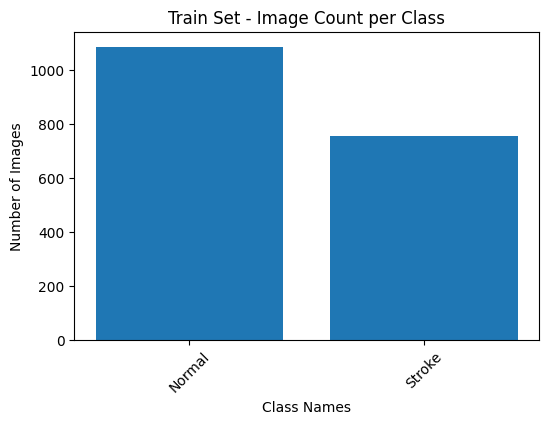


Validation set:
  - Normal: 157 images
  - Stroke: 78 images


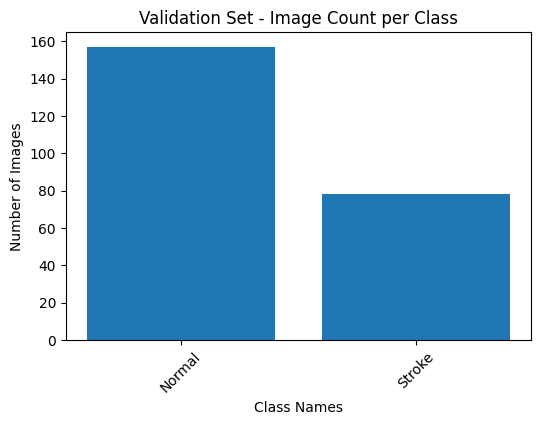


Test set:
  - Normal: 307 images
  - Stroke: 130 images


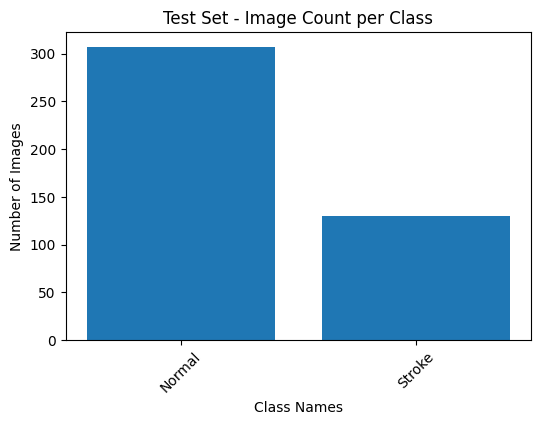

In [7]:
# Function to count images in each class
def count_images_per_class(path):
    path = Path(path)
    return {cls.name: len(list(cls.glob("*.*"))) for cls in path.iterdir() if cls.is_dir()}

# Show dataset distribution
print("Dataset distribution:")
for name, path in [("Train", trainpath), ("Validation", validpath), ("Test", testpath)]:
    counts = count_images_per_class(path)
    print(f"{name} set:")
    for cls, count in counts.items():
        print(f"  - {cls}: {count} images")

   # Plot counts for this split
    plt.figure(figsize=(6, 4))
    plt.bar(counts.keys(), counts.values())
    plt.title(f'{name} Set - Image Count per Class')
    plt.xlabel('Class Names')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()
    print()



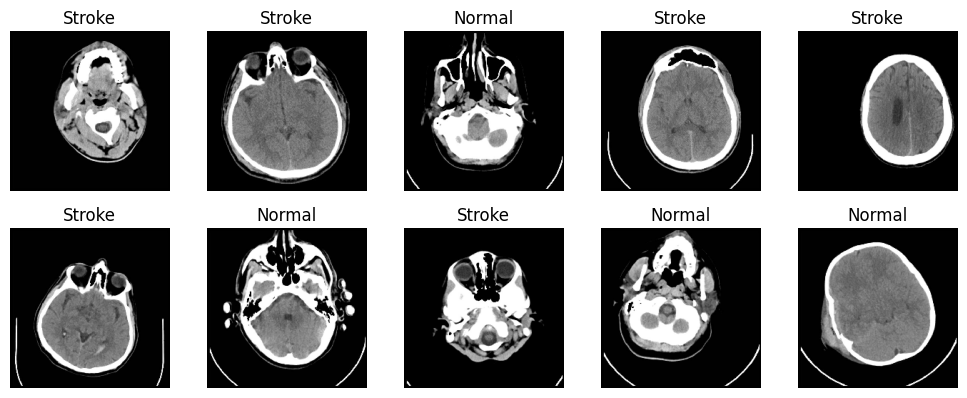

In [8]:
# visualizing from the train set


# Get one batch of data (images and labels)
images, labels = next(train_generator)

# Convert class indices to class names
class_names = list(train_generator.class_indices.keys())

# Plot 10 images from the batch
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    label = class_names[int(labels[i])]  # convert label to class name
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

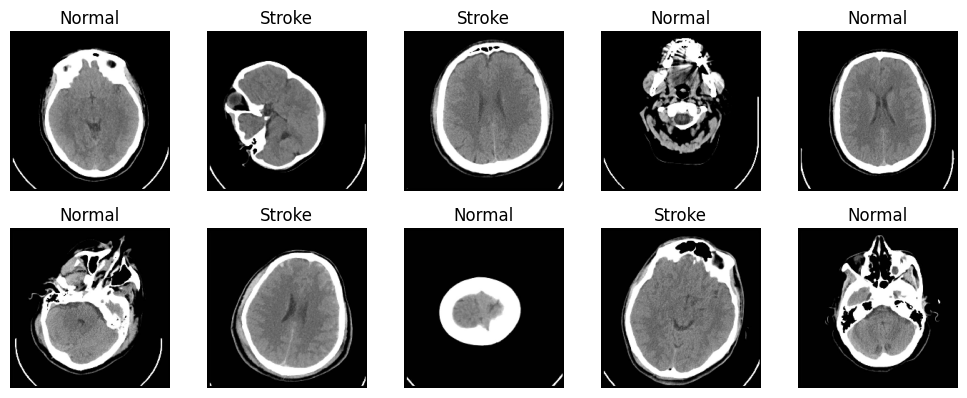

In [9]:
# visualizing fron the validation data


# Get one batch of data (images and labels)
images, labels = next(val_generator)

# Convert class indices to class names
class_names = list(val_generator.class_indices.keys())

# Plot 10 images from the batch
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    label = class_names[int(labels[i])]  # convert label to class name
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()


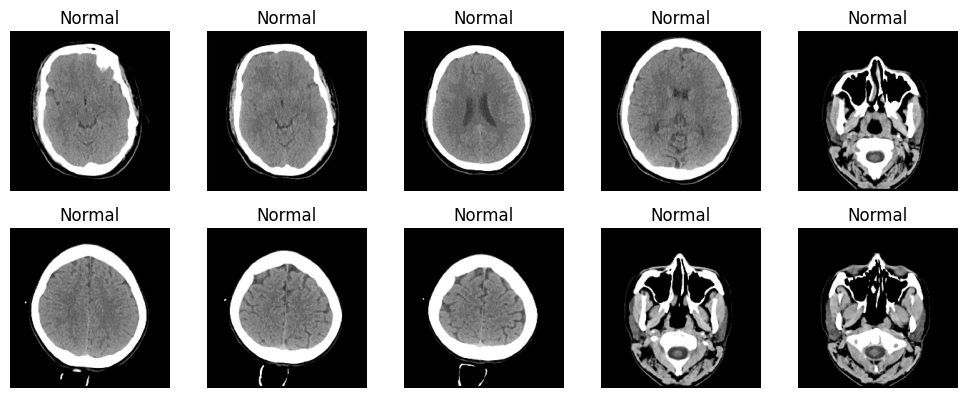

In [10]:
# visualizing from the test data
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of data (images and labels)
images, labels = next(test_generator)

# Convert class indices to class names
class_names = list(test_generator.class_indices.keys())

# Plot 10 images from the batch
plt.figure(figsize=(10, 10))
for i in range(10):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    label = class_names[int(labels[i])]  # convert label to class name
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()


In [11]:
'''

# Build the CNN model
# 1. Build the CNN model
def build_cnn():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after first block

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after second block

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after third block

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),           # drop before the output head
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


cnn_model = build_cnn()

# 2. EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# 3. Train the model
history = cnn_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)

# 4. Plot training and validation loss/accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

'''

"\n\n# Build the CNN model\n# 1. Build the CNN model\ndef build_cnn():\n    model = models.Sequential([\n        layers.Input(shape=(224, 224, 3)),\n\n        layers.Conv2D(32, (3,3), activation='relu', padding='same'),\n        layers.MaxPooling2D(),\n        layers.Dropout(0.3),          # drop after first block\n\n        layers.Conv2D(64, (3,3), activation='relu', padding='same'),\n        layers.MaxPooling2D(),\n        layers.Dropout(0.3),          # drop after second block\n\n        layers.Conv2D(128, (3,3), activation='relu', padding='same'),\n        layers.MaxPooling2D(),\n        layers.Dropout(0.3),          # drop after third block\n\n        layers.Flatten(),\n        layers.Dense(128, activation='relu'),\n        layers.Dropout(0.3),           # drop before the output head\n        layers.Dense(1, activation='sigmoid')\n    ])\n    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n    return model\n\n\ncnn_model = build_cnn()\n\n# 2. Ear

In [12]:
'''

# Evaluating the trained model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get true labels and predicted probabilities from the test set
y_true = []
y_pred = []
y_prob = []

# Loop through test set batches
for images, labels in test_generator:
    preds = cnn_model.predict(images)
    y_prob.extend(preds.ravel())
    y_pred.extend((preds > 0.5).astype(int).ravel())
    y_true.extend(labels)

    if len(y_true) >= test_generator.samples:
        break

# Step 2: Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Step 3: Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Step 4: Print metrics
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()

# Step 6: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

'''

'\n\n# Evaluating the trained model\n\nfrom sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve\nimport numpy as np\nimport matplotlib.pyplot as plt\n\n# Step 1: Get true labels and predicted probabilities from the test set\ny_true = []\ny_pred = []\ny_prob = []\n\n# Loop through test set batches\nfor images, labels in test_generator:\n    preds = cnn_model.predict(images)\n    y_prob.extend(preds.ravel())\n    y_pred.extend((preds > 0.5).astype(int).ravel())\n    y_true.extend(labels)\n\n    if len(y_true) >= test_generator.samples:\n        break\n\n# Step 2: Convert to numpy arrays\ny_true = np.array(y_true)\ny_pred = np.array(y_pred)\ny_prob = np.array(y_prob)\n\n# Step 3: Compute metrics\nacc = accuracy_score(y_true, y_pred)\nprec = precision_score(y_true, y_pred)\nrec = recall_score(y_true, y_pred)\nf1 = f1_score(y_true, y_pred)\ncm = confusion_matrix(y_true, y_pred)\nauc = roc_auc_score(y_true, y_prob)\n\n# S

In [13]:
                  # Build CNN with weighted balancing

# 1. Build the CNN model
def build_cnn():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after first block

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after second block

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Dropout(0.3),          # drop after third block

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),           # drop before the output head
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model_1 = build_cnn()

# 2. EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# ---------------------------
# Compute class weights
# ---------------------------
# 0 = Normal, 1 = Stroke
classes = np.array([0, 1])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_generator.classes  # labels from generator
)
class_weights = dict(enumerate(class_weights))

# ---------------------------
# Train the model
# ---------------------------
history = cnn_model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

cnn_model_1.summary()



Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 793ms/step - accuracy: 0.5952 - loss: 0.7975 - val_accuracy: 0.6723 - val_loss: 0.6112
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 723ms/step - accuracy: 0.7797 - loss: 0.4629 - val_accuracy: 0.8851 - val_loss: 0.3286
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 722ms/step - accuracy: 0.8779 - loss: 0.2798 - val_accuracy: 0.9234 - val_loss: 0.2170
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 724ms/step - accuracy: 0.9360 - loss: 0.1615 - val_accuracy: 0.9617 - val_loss: 0.1170
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 42s 717ms/step - accuracy: 0.9642 - loss: 0.0866 - val_accuracy: 0.9702 - val_loss: 0.0933
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 46s 786ms/step - accuracy: 0.9772 - loss: 0.0618 - val_accuracy: 0.9660 - val_loss: 0.1408
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 893ms/step - accuracy: 0.9783 - loss: 0.0520 - val_accuracy: 0.9702 - val_loss: 0.0692
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 853ms/step - accuracy: 0.9919 - loss: 0.0304 - val_accu

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      12,845,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,815,685 (148.07 MB)

 Trainable params: 12,938,561 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,877,124 (98.71 MB)

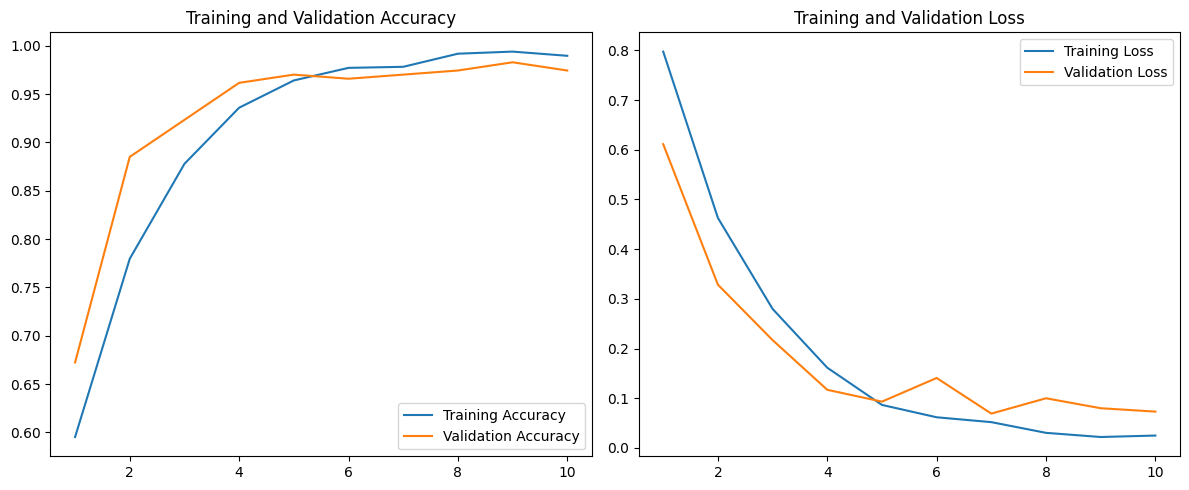

In [14]:
# 4. Plot training and validation loss/accuracy
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Accuracy:  0.9725
Precision: 0.9338
Recall:    0.9769
F1 Score:  0.9549
AUC:       0.9960

Confusion Matrix:
[[298   9]
 [  3 127]]


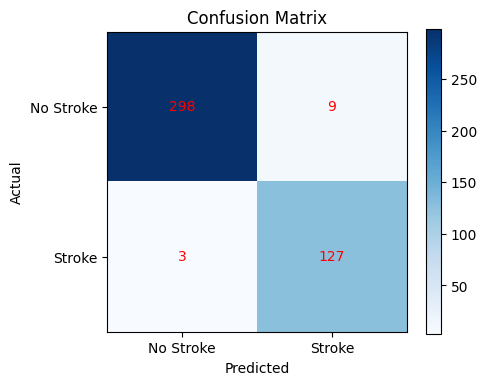

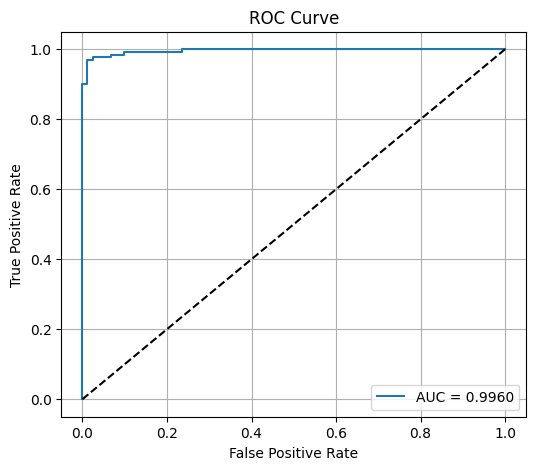

In [15]:
# Evaluating the trained model

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Get true labels and predicted probabilities from the test set
y_true = []
y_pred = []
y_prob = []

# Loop through test set batches
for images, labels in test_generator:
    preds = cnn_model_1.predict(images)
    y_prob.extend(preds.ravel())
    y_pred.extend((preds > 0.5).astype(int).ravel())
    y_true.extend(labels)

    if len(y_true) >= test_generator.samples:
        break

# Step 2: Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Step 3: Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
auc = roc_auc_score(y_true, y_prob)

# Step 4: Print metrics
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print("\nConfusion Matrix:")
print(cm)

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()

# Step 6: Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], 'k--')  # diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()


In [16]:
# visualizing the feature maps (activations) of a particular convolutional layer in a Sequential CNN model, given a specific input image.

from tensorflow.keras.models import Model

def plot_layer_activation(model, image, layer_name, images_per_row=8):
    """
    Visualize feature maps from a given  layer in a Sequential CNN model.
    """
    # Ensure image is float32 with batch dimension
    if image.ndim == 3:
        image = np.expand_dims(image, axis=0)
    image = image.astype(np.float32)

    # Extract chosen layer
    try:
        target_layer = model.get_layer(layer_name)
    except ValueError:
        print(f"Layer {layer_name} not found in model.")
        return

    # Build functional model from input -> target layer
    activation_model = Model(inputs=model.layers[0].input,  # ✅ explicit for Sequential
                             outputs=target_layer.output)

    # Run prediction safely (use .predict instead of __call__)
    activations = activation_model.predict(image)

    # activations shape → (1, height, width, channels)
    n_features = activations.shape[-1]
    size = activations.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = activations[0, :, :, col * images_per_row + row]

            # Normalize for display
            channel_image -= channel_image.mean()
            channel_image /= (channel_image.std() + 1e-8)
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')

            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(f"Activations from {layer_name}")
    plt.grid(False)
    plt.axis('off')
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


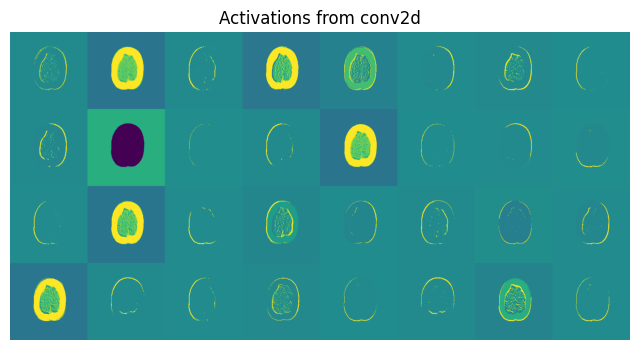

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


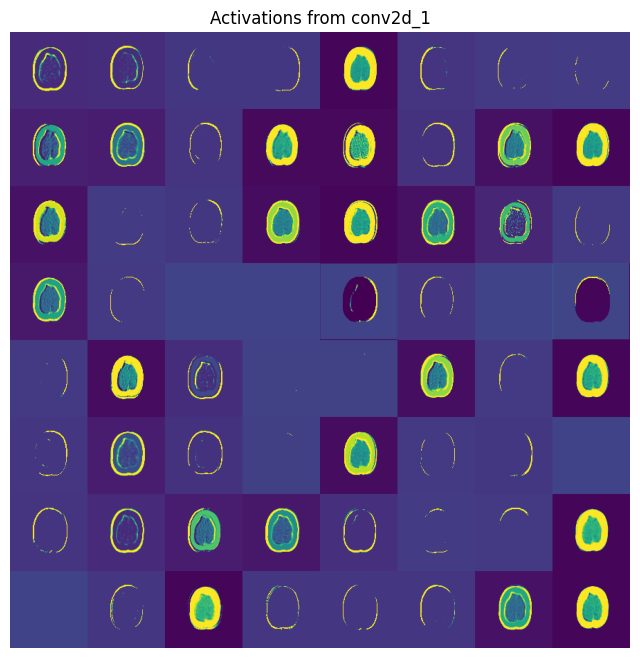

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


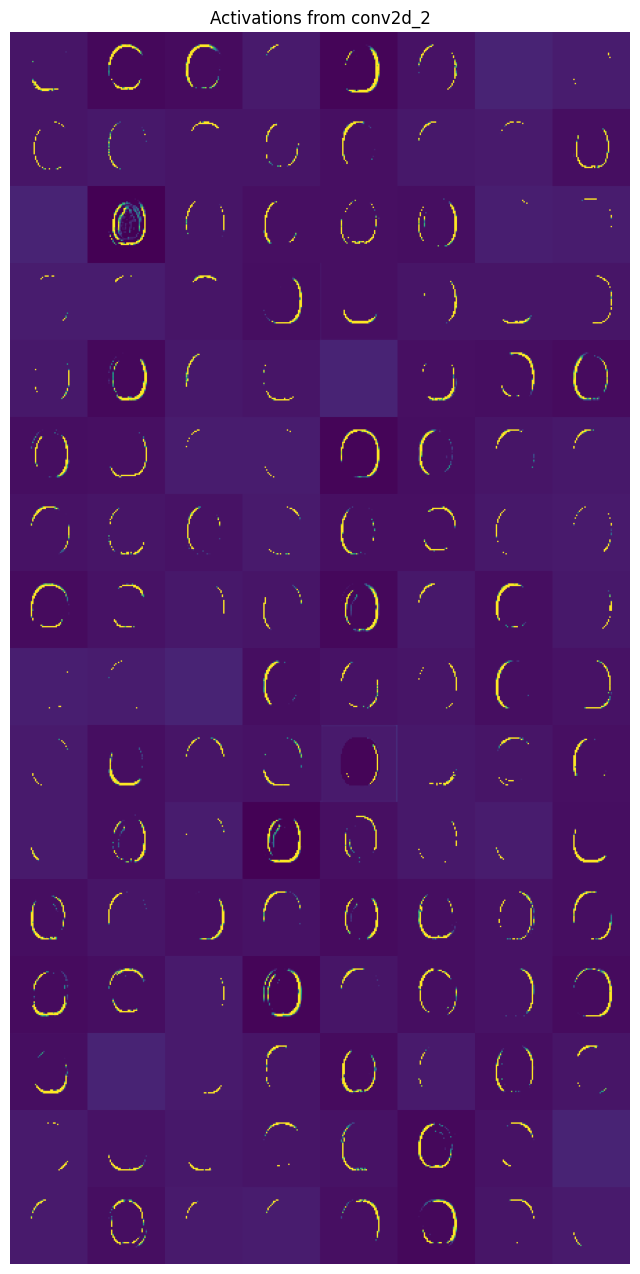

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


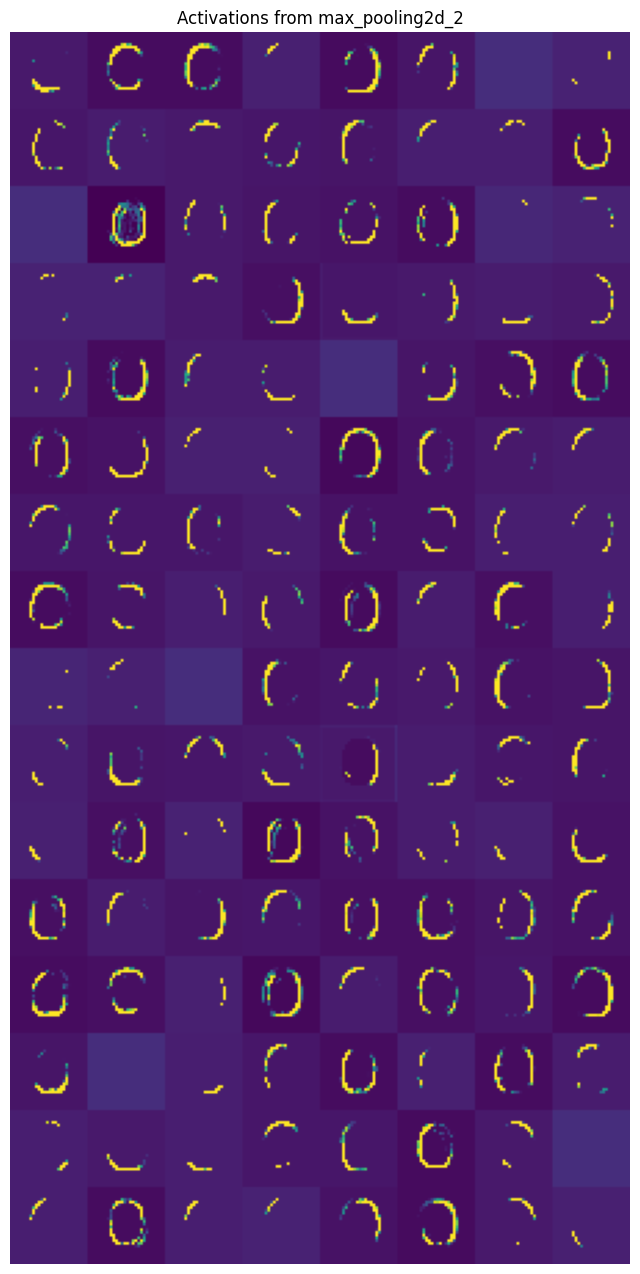

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


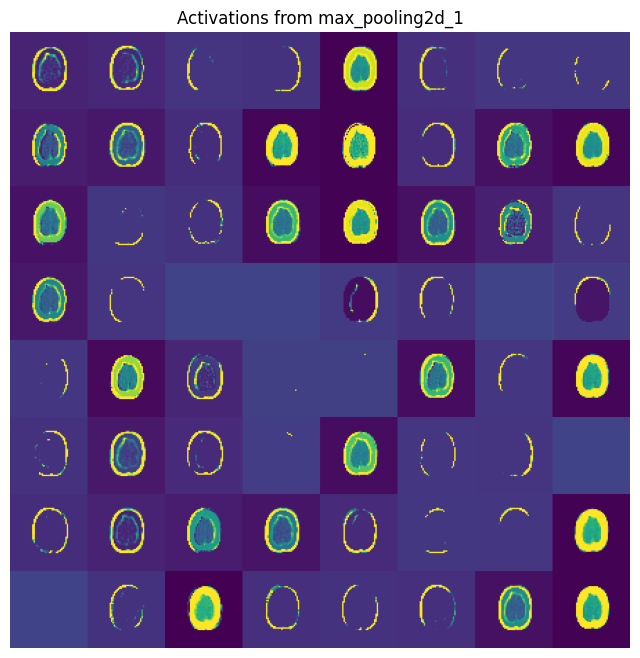

In [17]:
# Get a batch from the generator
x_batch, y_batch = test_generator[0]  # shape: (batch_size, H, W, 3)

# Pick a random index
idx = np.random.randint(0, x_batch.shape[0])
img = x_batch[idx]

plot_layer_activation(cnn_model_1, img, layer_name="conv2d")
plot_layer_activation(cnn_model_1, img, layer_name="conv2d_1")
plot_layer_activation(cnn_model_1, img, layer_name="conv2d_2")
plot_layer_activation(cnn_model_1, img, layer_name="max_pooling2d_2")
plot_layer_activation(cnn_model_1, img, layer_name="max_pooling2d_1")

In [18]:
                         # Building Vit
# imports and set up
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
#from transformers import TFViTModel, ViTImageProcessor
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


# 1. PatchEmbedding Layer

## What is it?

This custom Keras layer divides the input image into small, equally sized patches and projects each patch into a vector using a dense (fully connected) layer.

## How does it work?

tf.image.extract_patches splits the image tensor into non-overlapping patches.

The patches are flattened and projected to a desired dimension (hidden_dim) via a Dense layer.

The output is a sequence of patch embeddings, similar to word embeddings in NLP.

## Use:

To prepare image data as a sequence for the transformer.

# 2. VisionTransformer (ViT) Model

## What is it?

This is the main ViT class, implemented as a custom Keras Model. It builds a transformer encoder stack for images.

## Subcomponents:

patch_embed – Converts images to patch embeddings as described above.

cls_token – A learnable [CLS] token prepended to the patch sequence to aggregate information, as done in BERT (NLP).

pos_embed – Learnable positional embedding added to each patch (plus [CLS]) encoding spatial info lost by flattening.

transformer_layers, mha_layers, mlp_layers – Multiple transformer encoder blocks, each with:

Layer Normalization for stable training.

Multi-Head Attention (MHA) for mixing information across patches.

MLP (feedforward) for nonlinear processing.

Dropout for regularization.

norm – Final normalization.

head – Dense output layer with sigmoid activation (set up for binary classification).

## How does it work?

Embedding & sequence formatting: Input image → Patch embedding → Add [CLS] token → Add positional embedding.

Transformer encoding: Apply several layers of normalization, multi-head attention, skip connections, and MLP.

Classification: Use only the [CLS] token’s output (summary of full image) → Dense layer with sigmoid activation for binary output.

# 3. Hyperparameters and Model Instantiation

## Parameters:

image_size: Input image resolution (height, width).

patch_size: Size of each square patch.

num_layers: Number of transformer blocks.

num_heads: Number of attention heads in each block.

hidden_dim: Dimension of embeddings and attention.

mlp_dim: Dimension of the inner MLP.

dropout_rate: Dropout rate for regularization.

# Model creation:

Instantiates the ViT model with the specified configuration.

Compiles it for binary image classification using Adam optimizer and binary cross-entropy loss.

Tracks accuracy and AUC (area under the curve) as metrics.

## What Is It Used For?

## Purpose: This code sets up a Vision Transformer for binary image classification (such as distinguishing between two classes, e.g., cat vs. dog, or healthy vs. diseased).

## Use-Case: Delivers state-of-the-art performance on image tasks and can be adapted to multi-class classification by changing the final layer.



In [19]:

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import keras_cv
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ------------------- Vision Transformer -------------------
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, hidden_dim):
        super().__init__()
        self.patch_size = patch_size
        self.hidden_dim = hidden_dim
        self.proj = layers.Dense(hidden_dim)

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding='VALID'
        )
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return self.proj(patches)

class VisionTransformer(models.Model):
    def __init__(self, image_size, patch_size, num_layers, num_heads, hidden_dim, mlp_dim, dropout_rate):
        super().__init__()
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_embed = PatchEmbedding(patch_size, hidden_dim)
        self.cls_token = tf.Variable(tf.zeros((1, 1, hidden_dim)), trainable=True)
        self.pos_embed = tf.Variable(tf.zeros((1, self.num_patches + 1, hidden_dim)), trainable=True)

        self.transformer_layers = [
            layers.LayerNormalization(epsilon=1e-6) for _ in range(num_layers)
        ]
        self.mha_layers = [
            layers.MultiHeadAttention(num_heads=num_heads, key_dim=hidden_dim) for _ in range(num_layers)
        ]
        self.mlp_layers = [
            models.Sequential([
                layers.Dense(mlp_dim, activation='gelu'),
                layers.Dropout(dropout_rate),
                layers.Dense(hidden_dim),
                layers.Dropout(dropout_rate)
            ]) for _ in range(num_layers)
        ]
        self.norm = layers.LayerNormalization(epsilon=1e-6)
        self.head = layers.Dense(1, activation='sigmoid')  # binary output

    def call(self, x):
        batch_size = tf.shape(x)[0]
        x = self.patch_embed(x)
        cls_tokens = tf.broadcast_to(self.cls_token, [batch_size, 1, x.shape[-1]])
        x = tf.concat([cls_tokens, x], axis=1)
        x += self.pos_embed

        for ln, mha, mlp in zip(self.transformer_layers, self.mha_layers, self.mlp_layers):
            y = ln(x)
            y = mha(y, y)
            x = x + y
            x = x + mlp(ln(x))

        cls_output = self.norm(x[:, 0])
        return self.head(cls_output)

# ----------------- Hyperparameters -----------------

image_size = 224
patch_size = 16
batch_size = 16
num_layers = 6
num_heads = 8
hidden_dim = 128
mlp_dim = 256
dropout_rate = 0.25
epochs = 30
learning_rate=3e-4

# ----------------- Define vit_model -----------------
vit_model = VisionTransformer(
    image_size, patch_size, num_layers, num_heads,
    hidden_dim, mlp_dim, dropout_rate
)

vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name="auc")]
)


# ----------------- Train vit_model -----------------
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = vit_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    callbacks=[early_stop]
)


Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 118s 2s/step - accuracy: 0.5448 - auc: 0.4835 - loss: 0.7644 - val_accuracy: 0.6681 - val_auc: 0.5412 - val_loss: 0.6349
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5692 - auc: 0.5128 - loss: 0.6842 - val_accuracy: 0.6681 - val_auc: 0.5248 - val_loss: 0.6337
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5648 - auc: 0.4806 - loss: 0.6968 - val_accuracy: 0.3745 - val_auc: 0.5992 - val_loss: 0.6954
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5746 - auc: 0.5022 - loss: 0.6815 - val_accuracy: 0.3319 - val_auc: 0.5626 - val_loss: 0.7120
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5719 - auc: 0.4875 - loss: 0.6893 - val_accuracy: 0.6681 - val_auc: 0.6138 - val_loss: 0.6373
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5415 - auc: 0.4898 - loss: 0.7065 - val_accuracy: 0.3319 - val_auc: 0.7822 - val_loss: 0.7354
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/

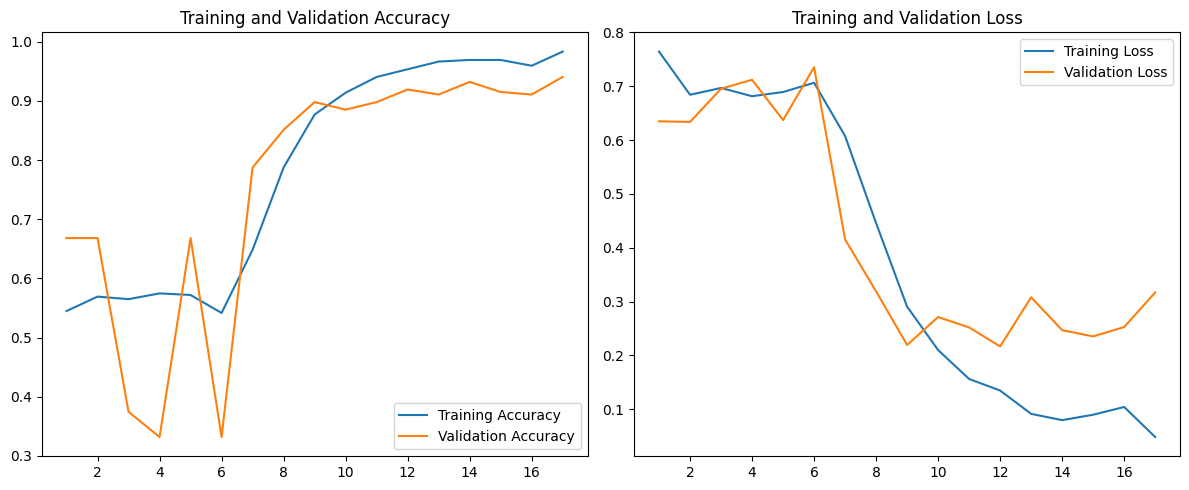

In [20]:
               #  Plot training and validation loss/accuracy

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [21]:


# ------------------- Evaluate loss & accuracy -------------------
test_loss, test_acc, test_auc = vit_model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test AUC: {test_auc:.4f}")



14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 538ms/step - accuracy: 0.9359 - auc: 0.9764 - loss: 0.1715
Test Loss: 0.1715
Test Accuracy: 0.9359
Test AUC: 0.9764


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 594ms/step
Accuracy:  0.9359
Precision: 0.9113
Recall:    0.8692
F1 Score:  0.8898
AUC:       0.9786

Confusion Matrix:
[[296  11]
 [ 17 113]]


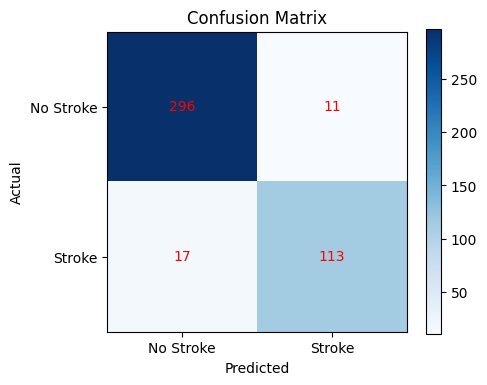

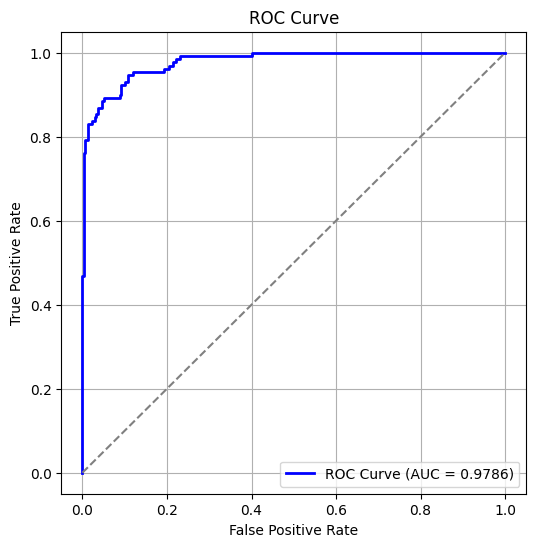

In [22]:
# --------------------
# Efficient GPU prediction
# --------------------
# Calculate the number of steps per epoch for the generator
steps = int(np.ceil(test_generator.samples / test_generator.batch_size))

# Predict all at once using generator
y_pred_probs = vit_model.predict(test_generator, steps=steps, verbose=1).flatten()
y_true = test_generator.classes  # true labels already in correct order

# Binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# --------------------
# Compute metrics
# --------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")

# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()
# --------------------
# ROC Curve
# --------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [23]:
from tensorflow.keras import Model, layers

# -------------------------
# Freeze base models
# -------------------------
cnn_model_1.trainable = False
vit_model.trainable = False

# -------------------------
# Define ensemble input
# -------------------------
inp = layers.Input(shape=(224, 224, 3))

# -------------------------
# Get feature outputs
# -------------------------
# Call the models on the input directly
cnn_feat = cnn_model_1(inp)  # CNN features
vit_feat = vit_model(inp)  # ViT features

# -------------------------
# Concatenate features
# -------------------------
concat = layers.Concatenate()([cnn_feat, vit_feat])
x = layers.Dense(16, activation="relu")(concat)
# x = layers.Dropout(0.3)(x)
final_out = layers.Dense(1, activation="sigmoid")(x)

# -------------------------
# Create ensemble model
# -------------------------
ensemble_model = Model(inputs=inp, outputs=final_out)

# Compile
ensemble_model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.Recall()]
)

ensemble_model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 1)                 │      12,938,561 │ input_layer_7[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ vision_transformer            │ (None, 1)                 │       3,660,801 │ input_layer_7[0][0]        │
│ (VisionTransformer)           │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 2)                 │               0 │ sequential[0][0],          │
│                               │                           │                 │ vision_transformer[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_16 (Dense)              │ (None, 16)                │              48 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_17 (Dense)              │ (None, 1)                 │              17 │ dense_16[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 16,599,427 (63.32 MB)

 Trainable params: 65 (260.00 B)

 Non-trainable params: 16,599,362 (63.32 MB)

In [24]:

#  Train ensemble model

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True
)

history = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 55s 856ms/step - accuracy: 0.5898 - loss: 0.7156 - recall: 0.0000e+00 - val_accuracy: 0.6681 - val_loss: 0.6777 - val_recall: 0.0000e+00
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 834ms/step - accuracy: 0.6435 - loss: 0.6579 - recall: 0.1310 - val_accuracy: 0.9064 - val_loss: 0.6209 - val_recall: 0.7308
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 841ms/step - accuracy: 0.9528 - loss: 0.5920 - recall: 0.8849 - val_accuracy: 0.9277 - val_loss: 0.5562 - val_recall: 0.7949
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 49s 851ms/step - accuracy: 0.9783 - loss: 0.5188 - recall: 0.9471 - val_accuracy: 0.9404 - val_loss: 0.4854 - val_recall: 0.8333
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 824ms/step - accuracy: 0.9886 - loss: 0.4418 - recall: 0.9722 - val_accuracy: 0.9617 - val_loss: 0.4131 - val_recall: 0.8974
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 854ms/step - accuracy: 0.9940 - loss: 0.3627 - recall: 0.9868 - val_accuracy: 0.9787 - val_loss: 0.3435 - val_recal

In [25]:

#  Evaluate on validation set

val_loss, val_acc, val_recall = ensemble_model.evaluate(test_generator)
print(f"Test Accuracy: {val_acc:.4f}")
print(f"Test Loss: {val_loss:.4f}")
print(f"Test Recall: {val_recall:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 645ms/step - accuracy: 0.9840 - loss: 0.1598 - recall: 0.9769
Test Accuracy: 0.9840
Test Loss: 0.1598
Test Recall: 0.9769


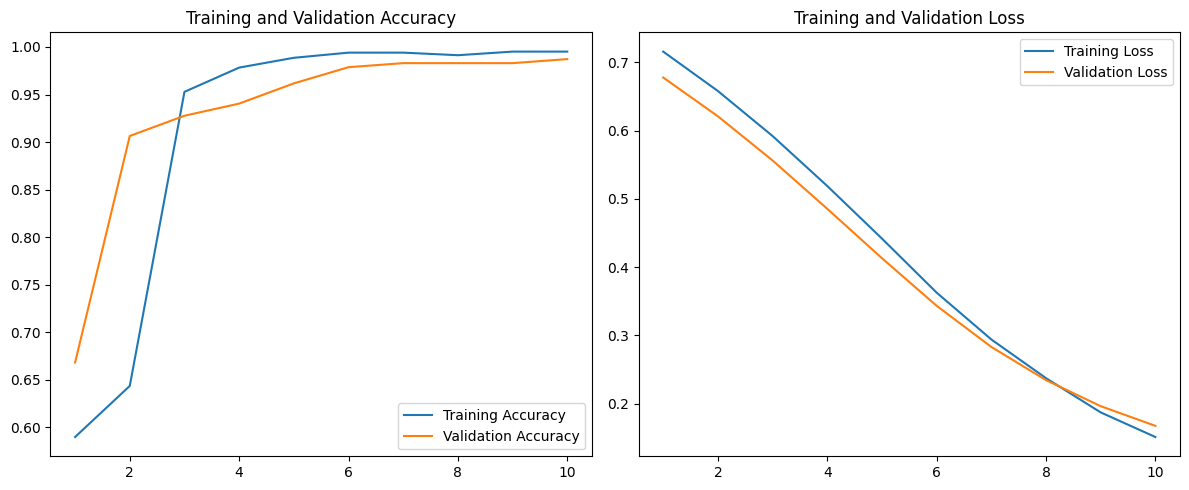

In [26]:
               #  Plot training and validation loss/accuracy

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 726ms/step
Accuracy:  0.9840
Precision: 0.9695
Recall:    0.9769
F1 Score:  0.9732
AUC:       0.9990

Confusion Matrix:
[[303   4]
 [  3 127]]


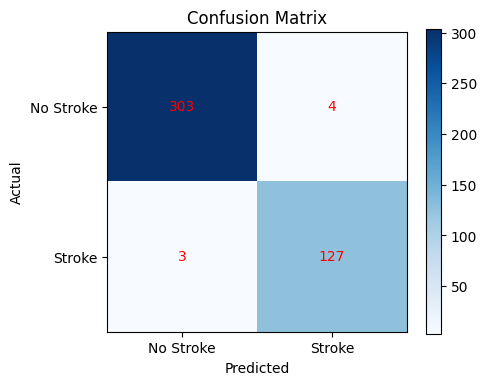

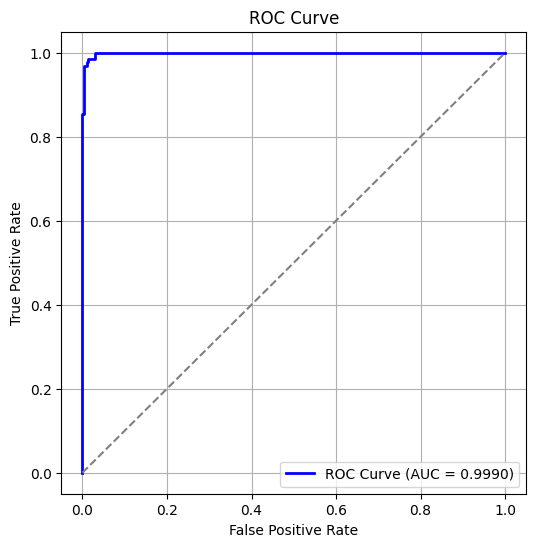

In [27]:
# --------------------
# Efficient GPU prediction for ensemble
# --------------------
steps = int(np.ceil(len(test_generator)))  # total batches in generator

# Predict all at once on GPU
y_pred_probs = ensemble_model.predict(test_generator, steps=steps, verbose=1).flatten()

# True labels
if hasattr(test_generator, "classes"):
    y_true = test_generator.classes  # works for DirectoryIterator
else:
    # For custom Sequence generators
    y_true = np.concatenate([y for _, y in test_generator], axis=0).flatten()

# Binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# --------------------
# Compute metrics
# --------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")


# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()
# --------------------
# ROC Curve
# --------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [28]:
                                                        # second ensemble model

cnn_pred = cnn_model_1(inp)
vit_pred = vit_model(inp)

avg_out = layers.Average()([cnn_pred, vit_pred])

ensemble_model_1 = Model(inputs=inp, outputs=avg_out)
# Early stopping
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Compile
ensemble_model_1.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Train
history = ensemble_model_1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=[early_stop]
)


Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 52s 865ms/step - accuracy: 0.9957 - auc: 0.9999 - loss: 0.0504 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 811ms/step - accuracy: 0.9957 - auc: 0.9999 - loss: 0.0485 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 811ms/step - accuracy: 0.9946 - auc: 1.0000 - loss: 0.0498 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 808ms/step - accuracy: 0.9957 - auc: 1.0000 - loss: 0.0492 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 47s 810ms/step - accuracy: 0.9957 - auc: 1.0000 - loss: 0.0477 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 48s 819ms/step - accuracy: 0.9946 - auc: 1.0000 - loss: 0.0485 - val_accuracy: 0.9745 - val_auc: 0.9970 - val_loss: 0.0886
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━

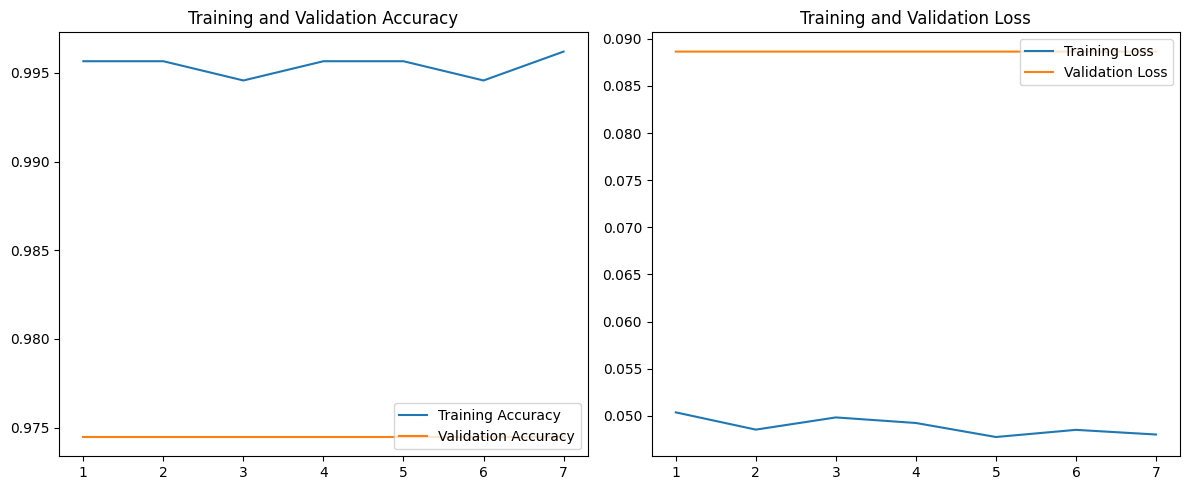

In [29]:
               #  Plot training and validation loss/accuracy

def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

plot_training_history(history)

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 697ms/step
Accuracy:  0.9863
Precision: 0.9844
Recall:    0.9692
F1 Score:  0.9767
AUC:       0.9990

Confusion Matrix:
[[305   2]
 [  4 126]]


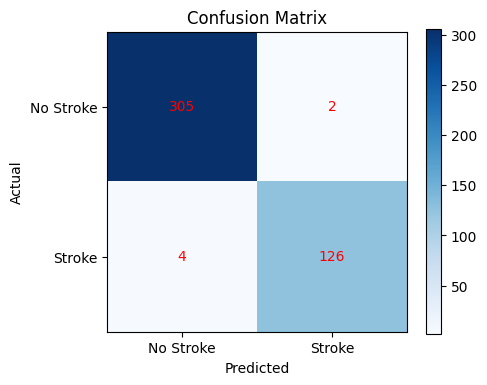

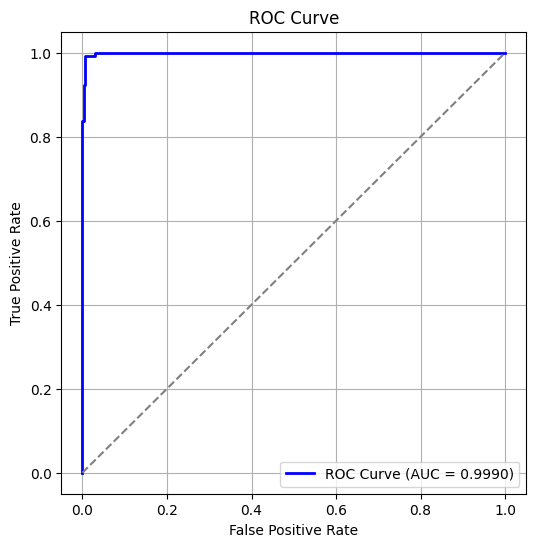

In [30]:
# --------------------
# Efficient GPU prediction for ensemble
# --------------------
steps = int(np.ceil(len(test_generator)))  # total batches in generator

# Predict all at once on GPU
y_pred_probs = ensemble_model_1.predict(test_generator, steps=steps, verbose=1).flatten()

# True labels
if hasattr(test_generator, "classes"):
    y_true = test_generator.classes  # works for DirectoryIterator
else:
    # For custom Sequence generators
    y_true = np.concatenate([y for _, y in test_generator], axis=0).flatten()

# Binary predictions
y_pred = (y_pred_probs > 0.5).astype(int)

# --------------------
# Compute metrics
# --------------------
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_probs)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"AUC:       {auc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")


# Step 5: Plot confusion matrix
plt.figure(figsize=(5, 4))
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['No Stroke', 'Stroke'])
plt.yticks(tick_marks, ['No Stroke', 'Stroke'])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.tight_layout()
plt.show()
# --------------------
# ROC Curve
# --------------------
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# Occlusion sensitivity - What It Does

Occlusion sensitivity identifies which regions of an input image are most important for the model’s prediction. It works by systematically "hiding" (occluding) small patches of the image and measuring how much the prediction changes when each patch is hidden.

## Code Explanation

occlusion_sensitivity(model, img, patch_size=32, stride=32):

model: Your trained CNN model.

img: The input image, as a NumPy array with shape (height, width, channels).

patch_size: Size of the square patch to occlude. Defaults to 32 pixels.

stride: How many pixels to move the patch each time. Defaults to 32.

Steps:

Baseline Prediction: Compute the model’s prediction on the original image.

Occlusion Loop: For each patch location (based on the stride):

Copy the image.

Set the selected patch to zero (effectively "hiding" it).

Predict using the occluded image.

Store the decrease in the predicted value at the location of the patch.

Heatmap:

Areas that, when occluded, reduce the prediction the most are considered important.

Normalizes and thresholds the heatmap for display.

## Visualization

The code overlays the occlusion sensitivity heatmap (in jet colors) over the original image.

Brighter colors mean the region is more important to the model's prediction.

In [31]:
# Get a batch from the generator
x_batch, y_batch = test_generator[0]  # shape: (batch_size, H, W, 3)

# Pick a random index
idx = np.random.randint(0, x_batch.shape[0])
img = x_batch[idx]

# Optional: get its label
label = y_batch[idx]

print(f"Picked random image index: {idx}, label: {label}")


Picked random image index: 3, label: 0.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

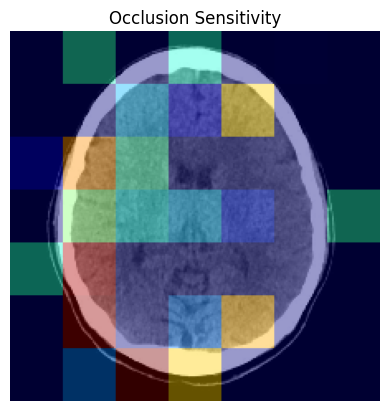

In [32]:

# occlusion_sensitivity for cnn_mode

def occlusion_sensitivity(model, img, patch_size=32, stride=32):
    height, width, _ = img.shape
    heatmap = np.zeros((height, width))
    baseline_pred = model.predict(np.expand_dims(img, axis=0))[0][0]

    for y in range(0, height, stride):
        for x in range(0, width, stride):
            img_occluded = img.copy()
            img_occluded[y:y+patch_size, x:x+patch_size, :] = 0.0
            pred = model.predict(np.expand_dims(img_occluded, axis=0))[0][0]
            heatmap[y:y+patch_size, x:x+patch_size] = baseline_pred - pred

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

# Example usage
occ_heatmap = occlusion_sensitivity(cnn_model_1, img)
plt.imshow(img)
plt.imshow(occ_heatmap, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Occlusion Sensitivity")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━

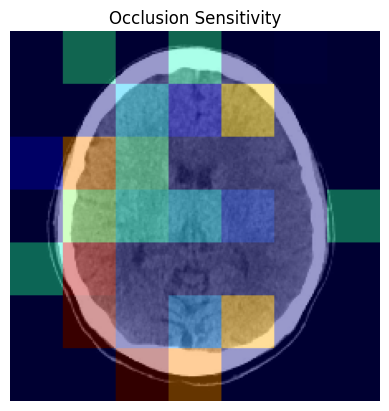

In [33]:

# occlusion_sensitivity ensemble model
occ_heatmap = occlusion_sensitivity(ensemble_model, img)
plt.imshow(img)
plt.imshow(occ_heatmap, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Occlusion Sensitivity")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━

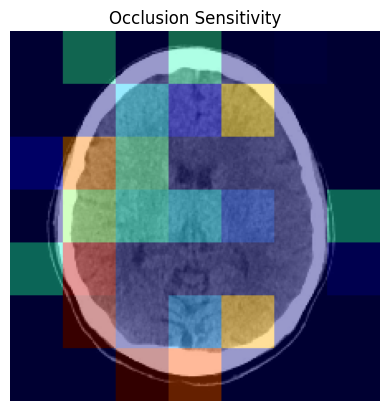

In [34]:

# occlusion_sensitivity second ensemble model
occ_heatmap = occlusion_sensitivity(ensemble_model_1, img)
plt.imshow(img)
plt.imshow(occ_heatmap, cmap='jet', alpha=0.4)
plt.axis('off')
plt.title("Occlusion Sensitivity")
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 67.95it/s]


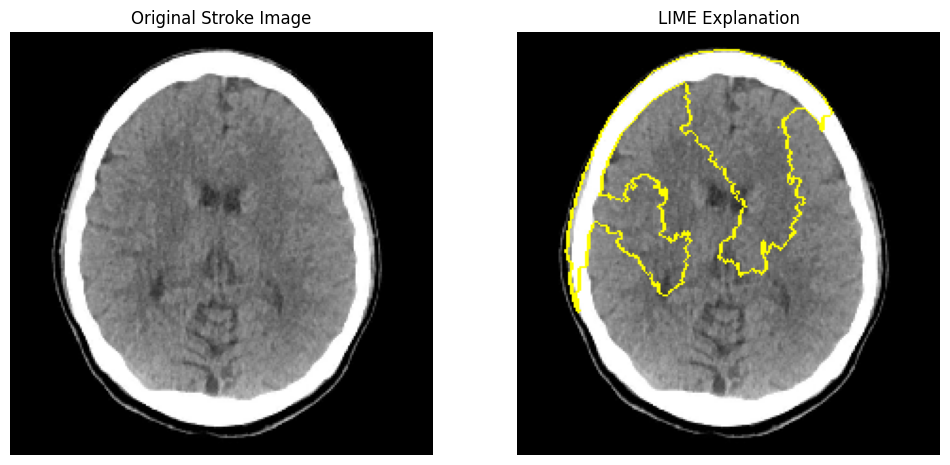

In [35]:
# Lime explainer for cnn model

import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm


explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    processed = np.array([image / 255.0 for image in images])
    preds = cnn_model_1.predict(processed, verbose=0)
    return np.concatenate([1 - preds, preds], axis=1)  # binary class probs

# Custom wrapper to show tqdm progress
class ProgressLimeImageExplainer(lime_image.LimeImageExplainer):
    def explain_instance(self, *args, **kwargs):
        num_samples = kwargs.pop('num_samples', 1000)
        # wrap the original random sampling loop with tqdm
        self._num_samples = num_samples
        return super().explain_instance(*args, num_samples=num_samples, **kwargs)

# Use the custom explainer
explainer = ProgressLimeImageExplainer()
explanation = explainer.explain_instance(
    img.astype('double'),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get image and mask
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=False)

# -----------------------
# Display original + LIME
# -----------------------
plt.figure(figsize=(12,6))

# Original
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Stroke Image")
plt.axis('off')

# LIME overlay
plt.subplot(1,2,2)
# Ensure the image is 0-1 for proper overlay
plt.imshow(mark_boundaries(img, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.show()


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.16it/s]


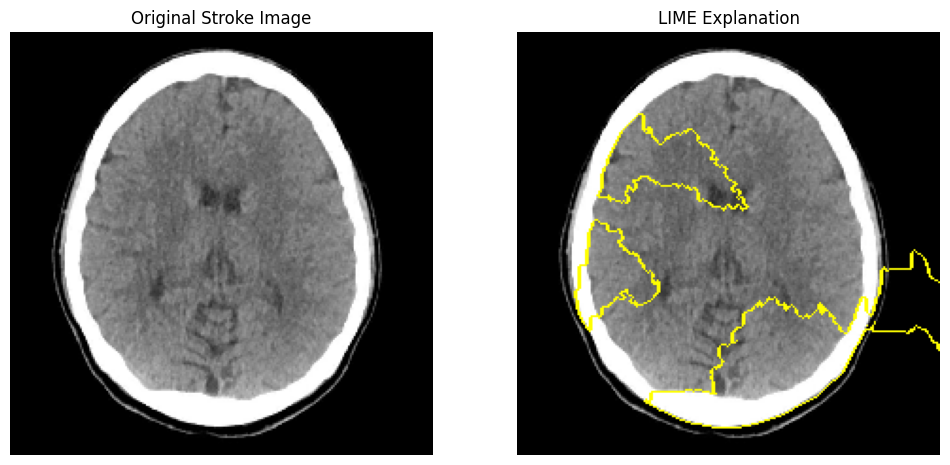

In [36]:
# Lime explainer for vit model

import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm


explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    processed = np.array([image / 255.0 for image in images])
    preds = vit_model.predict(processed, verbose=0)
    return np.concatenate([1 - preds, preds], axis=1)  # binary class probs

# Custom wrapper to show tqdm progress
class ProgressLimeImageExplainer(lime_image.LimeImageExplainer):
    def explain_instance(self, *args, **kwargs):
        num_samples = kwargs.pop('num_samples', 1000)
        # wrap the original random sampling loop with tqdm
        self._num_samples = num_samples
        return super().explain_instance(*args, num_samples=num_samples, **kwargs)

# Use the custom explainer
explainer = ProgressLimeImageExplainer()
explanation = explainer.explain_instance(
    img.astype('double'),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get image and mask
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=False)

# -----------------------
# Display original + LIME
# -----------------------
plt.figure(figsize=(12,6))

# Original
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Stroke Image")
plt.axis('off')

# LIME overlay
plt.subplot(1,2,2)
# Ensure the image is 0-1 for proper overlay
plt.imshow(mark_boundaries(img, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.show()

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.51it/s]


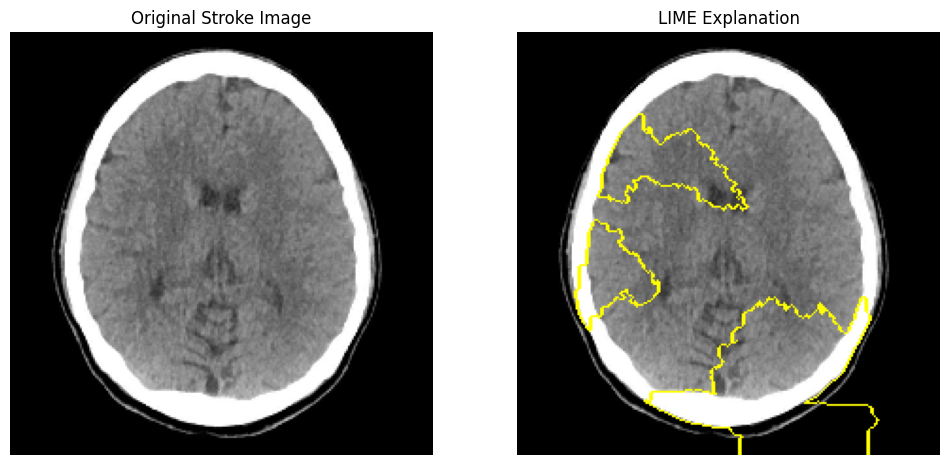

In [37]:
# Lime explainer for ensemble model

explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    processed = np.array([image / 255.0 for image in images])
    preds = ensemble_model.predict(processed, verbose=0)
    return np.concatenate([1 - preds, preds], axis=1)  # binary class probs

# Custom wrapper to show tqdm progress
class ProgressLimeImageExplainer(lime_image.LimeImageExplainer):
    def explain_instance(self, *args, **kwargs):
        num_samples = kwargs.pop('num_samples', 1000)
        # wrap the original random sampling loop with tqdm
        self._num_samples = num_samples
        return super().explain_instance(*args, num_samples=num_samples, **kwargs)

# Use the custom explainer
explainer = ProgressLimeImageExplainer()
explanation = explainer.explain_instance(
    img.astype('double'),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get image and mask
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=False)

# -----------------------
# Display original + LIME
# -----------------------
plt.figure(figsize=(12,6))

# Original
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Stroke Image")
plt.axis('off')

# LIME overlay
plt.subplot(1,2,2)
# Ensure the image is 0-1 for proper overlay
plt.imshow(mark_boundaries(img, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.show()


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.71it/s]


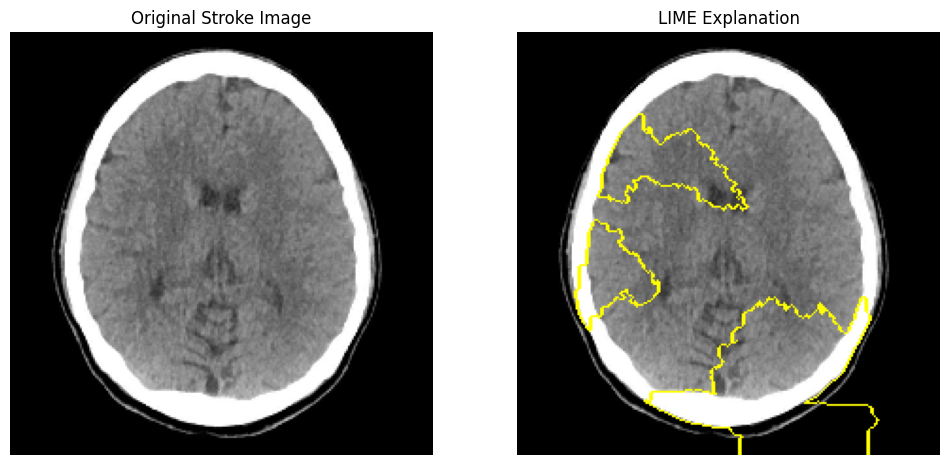

In [38]:
# Lime explainer for second ensemble model

explainer = lime_image.LimeImageExplainer()

def batch_predict(images):
    processed = np.array([image / 255.0 for image in images])
    preds = ensemble_model_1.predict(processed, verbose=0)
    return np.concatenate([1 - preds, preds], axis=1)  # binary class probs

# Custom wrapper to show tqdm progress
class ProgressLimeImageExplainer(lime_image.LimeImageExplainer):
    def explain_instance(self, *args, **kwargs):
        num_samples = kwargs.pop('num_samples', 1000)
        # wrap the original random sampling loop with tqdm
        self._num_samples = num_samples
        return super().explain_instance(*args, num_samples=num_samples, **kwargs)

# Use the custom explainer
explainer = ProgressLimeImageExplainer()
explanation = explainer.explain_instance(
    img.astype('double'),
    batch_predict,
    top_labels=2,
    hide_color=0,
    num_samples=1000
)

# Get image and mask
temp, mask = explanation.get_image_and_mask(label=1, positive_only=True, num_features=5, hide_rest=False)

# -----------------------
# Display original + LIME
# -----------------------
plt.figure(figsize=(12,6))

# Original
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Stroke Image")
plt.axis('off')

# LIME overlay
plt.subplot(1,2,2)
# Ensure the image is 0-1 for proper overlay
plt.imshow(mark_boundaries(img, mask))
plt.title("LIME Explanation")
plt.axis('off')

plt.show()